In [1]:
#mask
import json
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
import xml.etree.ElementTree as ET

In [2]:
#export format CoCo 
# open json file
path = "D:/Project2022/res/Datasets/mask_data/parse.json"

with open(path, ) as file:
    mask_data = json.load(file)

# Json structure

In [3]:
mask_data[0]["data"]["image"][14:]


'/47c54299-P104_98.png'

In [4]:
mask_data[0]["annotations"][0]["result"]

[{'original_width': 512,
  'original_height': 512,
  'image_rotation': 0,
  'value': {'x': 14.84374999999998,
   'y': 26.95312499999996,
   'width': 66.99218749999996,
   'height': 45.31249999999997,
   'rotation': 0,
   'rectanglelabels': ['Open lungs']},
  'id': 'VMZnXhZ4-0',
  'from_name': 'label',
  'to_name': 'image',
  'type': 'rectanglelabels',
  'origin': 'manual'}]

In [5]:
# returns an image and bb coordinates
def getBbox(img_array, x, y, width, height):
    coordinates = []
    
    #print(img)
    #img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    #img_array = cv2.resize(img_array, (512,512), interpolation= cv2.INTER_LINEAR)
    #print(img_array.shape)
    #bbox co ordinated -----> x1,y1   x2,y2
    #print(annatation["bbox"])
    #plt.imshow(img_array, cmap="gray")

    row = img_array.sum(axis=0)
    coloumn = img_array.sum(axis=1)

    #concat rows and coloumn
    concat_data = np.concatenate((row, coloumn))

    x1 = x/100*512
    y1 = y/100*512

    x2_temp = width/100*512
    y2_temp = height/100*512

    x2 = x1+x2_temp
    y2 = y1+y2_temp
    coordinates.append(int(x1))
    coordinates.append(int(y1))
    coordinates.append(int(x2))
    coordinates.append(int(y2))
    return concat_data, coordinates


## Fetch Dataset 

In [37]:
path = "D:/Project2022/res/Datasets/mask_data/images/"

raw_images= []
conacat_image = []
bb_cordinates = []

for data in tqdm(mask_data):
#for data, bb_data in zip(mask_data["image"], mask_data["label"]):
    #print(data["annotations"][0]["result"][0]["value"])

    if(len(data["annotations"][0]["result"]) != 0):
        x = data["annotations"][0]["result"][0]["value"]["x"]
        y = data["annotations"][0]["result"][0]["value"]["y"]
        width = data["annotations"][0]["result"][0]["value"]["width"]
        height = data["annotations"][0]["result"][0]["value"]["height"]


        #print(data["data"]["image"][15:])
        img = data["data"]["image"][15:]
        
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, (512,512), interpolation= cv2.INTER_LINEAR)
        data, label = getBbox(img_array, x, y, width, height)

        raw_images.append(img_array)
        conacat_image.append(data)
        bb_cordinates.append(label)

        plot_array = np.copy(img_array)

        cv2.rectangle(plot_array, (label[0], label[1]), (label[2], label[3]),color=(255, 0, 0), thickness=2)

        cv2.imwrite("D:/Project2022/res/Datasets/mask_data/output/"+img, plot_array)


        #plt.imshow(img_array)

        #print(data.shape)
        #print(label)
    
    
    

In [41]:
mask_df = pd.DataFrame()
mask_df["raw data"] = raw_images
mask_df["concat data"] = conacat_image
mask_df["bbox"] = bb_cordinates

In [42]:
mask_df.head()


,raw data,concat data,bbox
0,"[[2, 3, 2, 0, 2, 4, 1, 1, 2, 5, 4, 0, 0, 4, 3,...","[18381, 18619, 18847, 19111, 19284, 19356, 194...","[75, 137, 418, 369]"
1,"[[2, 2, 0, 0, 2, 3, 3, 1, 1, 3, 5, 3, 3, 1, 0,...","[18420, 18699, 18940, 19216, 19474, 19567, 196...","[75, 139, 419, 372]"
2,"[[0, 5, 6, 2, 0, 2, 5, 4, 0, 0, 4, 3, 0, 4, 5,...","[18244, 18490, 18691, 18850, 18979, 19150, 193...","[77, 140, 417, 368]"
3,"[[4, 3, 0, 2, 4, 1, 1, 1, 4, 3, 2, 2, 2, 3, 2,...","[18616, 18843, 19174, 19483, 19711, 19896, 201...","[72, 134, 421, 373]"
4,"[[2, 3, 0, 1, 3, 3, 4, 3, 3, 0, 1, 4, 2, 2, 2,...","[17932, 18136, 18369, 18557, 18712, 18818, 189...","[96, 168, 404, 355]"


In [43]:
#save data
mask_df.to_pickle("mask_bbox_large_dataset.pickle")

In [39]:
#-----------------    0                1
#combine_X -----> [["raw data"], ["concat data"]]
combine_df = pd.DataFrame()
combine_df["raw data"] = raw_images
combine_df["concat data"] = conacat_image

In [10]:
# Dataset shape
print("X shape:", np.array(conacat_image).shape, "\ny shape:", np.array(bb_cordinates).shape)

X shape: (1003, 1024) 
y shape: (1003, 4)


In [11]:
def data_reshape(array):
    data = []
    for sample in tqdm(array):
        data.append(list(sample))
    return np.array(data)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(combine_df, bb_cordinates, test_size = 0.2, random_state = 42)
#X_train, X_test, y_train, y_test = train_test_split(conacat_image, bb_cordinates, test_size = 0.2, random_state = 42)

In [13]:
#normalize the train data
from sklearn import preprocessing
norm_x = preprocessing.normalize(data_reshape(X_train["concat data"]))
norm_x_test = preprocessing.normalize(data_reshape(X_test["concat data"]))
norm_y = np.array(y_train)/512
norm_y_test = np.array(y_test)/512


In [14]:
# Define model
model = Sequential()
model.add(Dense(512, input_dim=1024, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(4))
#model.summary() #Print model Summary

In [15]:
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
model.fit(norm_x, norm_y, epochs=20)

Epoch 1/20
26/26 [==============================] - 0s 4ms/step - loss: 0.0727 - mean_squared_error: 0.0727
Epoch 2/20
26/26 [==============================] - 0s 4ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 3/20
26/26 [==============================] - 0s 4ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 4/20
26/26 [==============================] - 0s 4ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 5/20
26/26 [==============================] - 0s 4ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 6/20
26/26 [==============================] - 0s 4ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 7/20
26/26 [==============================] - 0s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 8/20
26/26 [==============================] - 0s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 9/20
26/26 [==============================] - 0s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 10/20
26/26 [=========

In [16]:
pred= model.predict(norm_x_test)

In [17]:
# de normalize the coordinates
y_actual = np.array(y_test)
y_pred = pred*512

In [18]:
print("No of test samples:", len(y_pred))

No of test samples: 201


## plot the predicted co-ordinates on the test data

In [19]:
path = "D:/Project2022/res/Datasets/mask/test"
test_samples = data_reshape(X_test["raw data"])
no = 1
for img_array, tcoor, coor  in zip(test_samples, y_actual, y_pred):
    file = "sample"+str(no)+".png"
    #plt.imshow(img_array, cmap="gray")
    #plt.show()
    #print(coor)

    cv2.putText(img_array, 'true', (int(tcoor[0]), int(tcoor[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    cv2.rectangle(img_array, 
        (int(tcoor[0]), int(tcoor[1])), 
        (int(tcoor[2]), int(tcoor[3])),
        color=(36, 255, 12), 
        thickness=3)

    
    cv2.putText(img_array, 'pred', (int(coor[0]), int(coor[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)
    cv2.rectangle(img_array, 
        (int(coor[0]), int(coor[1])), 
        (int(coor[2]), int(coor[3])),
        color=(255, 0, 0), 
        thickness=3)
    

    cv2.imwrite("D:/Project2022/Code/mask_keras/"+file,img_array)
    no += 1
    

In [20]:
combine_df.head()


,raw data,concat data
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[2223, 3732, 4834, 6379, 11850, 8998, 12112, 1..."
1,"[[235, 192, 192, 189, 186, 184, 186, 187, 188,...","[122215, 104347, 104330, 104359, 104509, 10462..."
2,"[[3, 2, 3, 4, 1, 2, 2, 6, 10, 9, 5, 8, 5, 8, 4...","[60762, 61542, 61730, 61470, 62124, 63013, 631..."
3,"[[0, 0, 0, 1, 4, 4, 4, 1, 0, 0, 0, 0, 0, 1, 4,...","[95, 122, 1751, 2144, 2339, 2592, 2825, 2968, ..."
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[2149, 3771, 4729, 6188, 11697, 8295, 9805, 10..."


In [22]:
conacat_image = np.array(conacat_image)
bb_cordinates = np.array(bb_cordinates)

In [27]:
conacat_image

array([[  2223,   3732,   4834, ...,  11848,   8679,   4208],
       [122215, 104347, 104330, ..., 102302, 101909, 101555],
       [ 60762,  61542,  61730, ...,  21574,  19069,  18695],
       ...,
       [  2874,   2797,   2871, ...,   1213,   1218,   1245],
       [  3072,   3163,   3377, ...,   1407,   1354,   1335],
       [  3025,   3191,   3128, ...,   1434,   1349,   1302]],
      dtype=uint32)

In [28]:
bb_cordinates

array([[ 82, 138, 408, 401],
       [ 11,  63, 483, 472],
       [ 18,  56, 464, 456],
       ...,
       [ 94, 152, 366, 380],
       [ 90, 160, 365, 379],
       [ 95, 156, 366, 386]])

X shape: (576, 1024) 
y shape: (576, 4)


In [29]:
#normalize the data
from sklearn import preprocessing
norm_x = preprocessing.normalize(conacat_image)
norm_y = bb_cordinates/512

In [31]:
#shape after normalizing the input
print("X shape:", norm_x.shape, "\ny shape:", norm_y.shape)

X shape: (576, 1024) 
y shape: (576, 4)


In [36]:
#dataset_X = np.expand_dims(conacat_image, axis=-1)
#dataset_y = np.expand_dims(bb_cordinates, axis=-1)

In [163]:
# after reshape
#print("X shape:", dataset_X.shape, "\ny shape:", dataset_y.shape)

In [51]:
mask_df.head()

,raw data,concat data,bbox
0,"[[2, 3, 2, 0, 2, 4, 1, 1, 2, 5, 4, 0, 0, 4, 3,...","[18381, 18619, 18847, 19111, 19284, 19356, 194...","[75, 137, 418, 369]"
1,"[[2, 2, 0, 0, 2, 3, 3, 1, 1, 3, 5, 3, 3, 1, 0,...","[18420, 18699, 18940, 19216, 19474, 19567, 196...","[75, 139, 419, 372]"
2,"[[0, 5, 6, 2, 0, 2, 5, 4, 0, 0, 4, 3, 0, 4, 5,...","[18244, 18490, 18691, 18850, 18979, 19150, 193...","[77, 140, 417, 368]"
3,"[[4, 3, 0, 2, 4, 1, 1, 1, 4, 3, 2, 2, 2, 3, 2,...","[18616, 18843, 19174, 19483, 19711, 19896, 201...","[72, 134, 421, 373]"
4,"[[2, 3, 0, 1, 3, 3, 4, 3, 3, 0, 1, 4, 2, 2, 2,...","[17932, 18136, 18369, 18557, 18712, 18818, 189...","[96, 168, 404, 355]"


In [ ]:
mask_df.head(1)

generate flipped dataset with bbox co ordinates## 

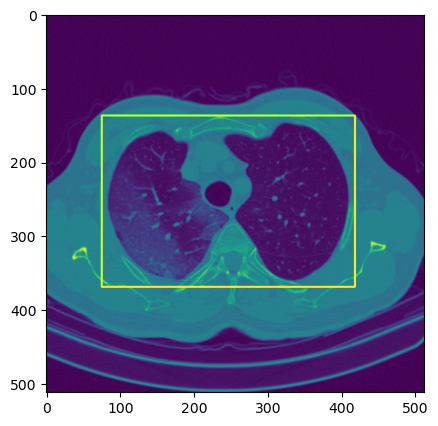

[75, 137, 418, 369]
[94, 137, 437, 369]


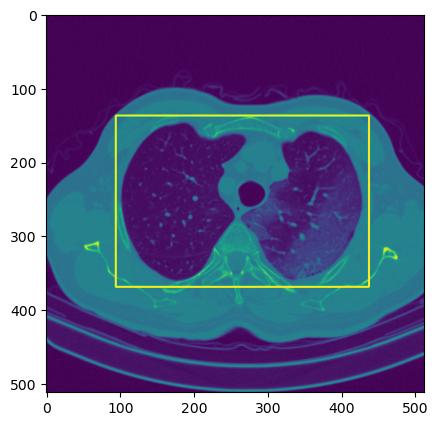

In [61]:

combine_df["raw data"][0]

for data, bbox in zip(mask_df["raw data"], mask_df["bbox"]):
    plt.figure(figsize=(5, 5), dpi=100)

    img = np.copy(data)
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]),color=(255, 0, 0), thickness=2)
    plt.imshow(img)
    plt.show()
    print(bbox)

    bbox_flip = [512-bbox[2], bbox[1], 512-bbox[0], bbox[3]]
    print(bbox_flip)

    img_flip = np.copy(data)
    plt.figure(figsize=(5, 5), dpi=100)
    img_flip = cv2.flip(img_flip, 1)

    # flipped bbox co-ordinates
    # x1 = 512-x2, y1
    # x2 = 512-x1, y2
    cv2.rectangle(img_flip, (bbox_flip[0], bbox_flip[1]), (bbox_flip[2], bbox[3]),color=(255, 0, 0), thickness=2)
    plt.imshow(img_flip)
    plt.show()

    break

In [185]:

# training data:
#    data_reshape(X_test["concat data"])

In [221]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()

In [250]:
#normalize the train data
from sklearn import preprocessing
norm_x = preprocessing.normalize(data_reshape(X_train["concat data"]))

regressor.fit(norm_x, y_train)
#regressor.fit(X_train, y_train)


LinearRegression()

In [251]:
print(regressor.intercept_)

[864.52114503 795.95790327 282.48744579 424.66961949]


In [252]:
print(regressor.coef_)

[[ 2530.68717038 -2393.96337298 -1765.15211206 ...  5954.60611869
    479.16311216  1083.39700722]
 [ 4416.91859153 -3371.93363168  -724.1136707  ...  8079.56078772
   -247.95600011  1283.29846406]
 [-2861.89986405   413.45878417 -1757.39441706 ... -2494.55632258
   1309.59438898   660.83931707]
 [-1103.19282436 -1831.00892795  4793.15421157 ... -3043.11170336
   -551.99515991   435.85550833]]


In [253]:
#normalize the test data
from sklearn import preprocessing
norm_test_x = preprocessing.normalize(data_reshape(X_test["concat data"]))

y_pred = regressor.predict(norm_test_x)
#y_pred = regressor.predict(X_test)

In [225]:
y_pred = y_pred.astype(int)

In [260]:
y_pred.shape

(116, 4)

In [258]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)


In [259]:
print(f'Mean absolute error: {mae:.2f}')


Mean absolute error: 40.43


In [79]:

# reshape for individual sample
y_pred = regressor.predict(X_test[1].reshape(1, -1) )
sample = X_test[1].reshape(1, -1)
sample.shape

80

c254aceb-6_Rahimzadeh_137covid_patient1_SR_4_IM00116.png
(512, 512)



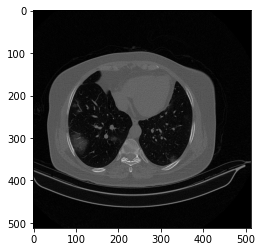

In [107]:
path = "D:/Project2022/res/Datasets/mask/test"

conacat_image = []
bb_cordinates = []
for file, annatation in tqdm(zip(mask_data["images"],mask_data["annotations"])):
    
    img = file["file_name"][9:]
    print(img)
    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    img_array = cv2.resize(img_array, (512,512), interpolation= cv2.INTER_LINEAR)
    print(img_array.shape)
    #bbox co ordinated -----> x1,y1   x2,y2
    #print(annatation["bbox"])
    plt.imshow(img_array, cmap="gray")
    cv2.rectangle(img_array, 
     (int(coor[0]), int(coor[1])), 
     (int(coor[2]), int(coor[3])),
     color=(255, 0, 0), 
     thickness=2)

    cv2.imwrite("mask/"+img,img_array)
    #cv2.imshow("Mask", img_array)
    #k = cv2.waitKey(0)
    break